In [1]:
import pandas as pd
import copy
import warnings
import csv
from datetime import date
import numpy as np

from sklearn import metrics
import matplotlib.pyplot as plt
import shap  # package used to calculate Shap values
from IPython.display import display, Image

import os
from os import listdir
from os.path import isfile, join

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
import time
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import xgboost as xgb
import shap
from tqdm import tqdm 


warnings.filterwarnings("ignore")

In [2]:
#Full results

df_ExtraTree = pd.read_csv('FINAL_EXTRA.csv')
df_DBFR = pd.read_csv('DBRF_Final_Results.csv')
df_ExtraTree['Algorithm Name'] = df_ExtraTree['Algorithm Name'].map(lambda algo_name: 'EXTRA TREES')

df_results = pd.concat([df_ExtraTree, df_DBFR])
df_results['Dataset Name'] = df_results['Dataset Name'].map(lambda data_name: data_name.rsplit('.',1)[0])
pd.DataFrame(df_results).to_csv("all_reslts.csv", index=False)


In [3]:
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

def save_results(parameters):
    today = str(date.today())
    ensure_dir(today)

    DIR = today
    index_file = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])

    with open(today + '/Meta_learning_Parameters' + str(index_file) + '.csv', 'w', newline='') as pred_file:
        pred_writer = csv.writer(pred_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        titles = ['Dataset Name','Algorithm Name','Accuracy','TPR','FPR',
          'Precision', 'AUC', 'PR-Curve', 'Training Time', 'Inference Time']

        pred_writer.writerow(titles)
        
        
        for current_dict in parameters:
            pred_writer.writerow([current_dict.get('Dataset Name'),
                     current_dict.get('Algorithm Name'),
                     current_dict.get('Accuracy'),
                     current_dict.get('TPR'),
                     current_dict.get('FPR'),
                     current_dict.get('Precision'),
                     current_dict.get('AUC'),
                     current_dict.get('PR-Curve'),
                     current_dict.get( 'Training Time'),
                     current_dict.get('Inference Time')])
                
        
    

In [4]:

def who_win(df_results,dataset_names):
    # this function get the auc results of each algorithm for all datasets
    # and returns dataframe contain binary label for each dataset which algorithm have the best auc result.

    #slice per algorithm
    ExtraTrees_results = df_results.loc[lambda df: df['Algorithm Name'] == 'EXTRA TREES', :]
    DBRF_results =  df_results.loc[lambda df: df['Algorithm Name'] == 'DBRF', :]
   
    rows_list = []
    for name_res,name_meta in tqdm(dataset_names):
    
        dict1 = {}
        dict2 = {}
        # slice per dataset
        ExtraTrees_results_dataset = ExtraTrees_results.loc[lambda df: df['Dataset Name'] == name_res,:]
        DBRF_results_dataset = DBRF_results.loc[lambda df: df['Dataset Name'] == name_res,:]
        #print("*********extra tree*********")
        #print(ExtraTrees_results_dataset.head(10))
        #print("DBRF")
        #print(DBRF_results_dataset.head(5))
        # best auc
        best_auc_ExtraTrees = ExtraTrees_results_dataset['AUC'].max()  
        best_auc_DBRF = DBRF_results_dataset['AUC'].max()  
        
        #print(best_auc_ExtraTrees)
        #print(best_auc_DBRF)
        #compare auc and save labels
        # who win?
        dict1 = { 'dataset': name_meta,
                 'Algorithm Name': 'EXTRA TREES',
                 'label':0 if best_auc_ExtraTrees < best_auc_DBRF else 1
                }
        dict2 = { 'dataset': name_meta,
                 'Algorithm Name': 'DBRF',
                 'label':1 if best_auc_ExtraTrees < best_auc_DBRF  else 0
                }
   
        
        # save the dict in a list                         
        rows_list.append(dict1)
        rows_list.append(dict2)


    # convert list to dataframe
    df_who_win = pd.DataFrame(rows_list)
    return df_who_win.copy()

In [5]:
def binary_params(X_train, X_test, y_train, y_test):

     # this function calculate the parameters for binary classification problems
    #and return a dictionary with the results
    
    
    #fit model
    
    model = xgb.XGBClassifier(random_state=1,learning_rate=0.01)


    #time.process_time() will measure the CPU time
    start1 = time.process_time()
    model.fit(X_train,y_train)
    train_time = time.process_time() - start1
    
    #prediction
    start2 = time.process_time()
    # predict probability that this model will win
    y_prob = model.predict_proba(X_test)[:, 1]
    predict_time = time.process_time() - start2
    
    y_pred = model.predict(X_test)


    #dataframe size
    r, c = X_test.shape
    
    # Scale
    infer_time = predict_time*(1000/r)
    
    #Accuracy
    #preds_classes = [x.index(max(x)) for x in prediction_probab]
    acc_score = accuracy_score(y_test, y_pred)
   
    # TPR, FPR ,Precision
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = tp/(tp+fn)
    
    # Fall out or false positive rate
    FPR = fp/(fp+tn)
    
    # Precision or positive predictive value
    #Precision = tp/(tp+fp)
    precision = precision_score(y_test, y_pred, average='binary')
    
     
    #auc calculation
    score = roc_auc_score(y_test, y_prob)
    
    #Area under Precision-Recall Curve 
    average_precision = average_precision_score(y_test, y_prob)
    
    #save all calculations in a dictionary
    params = {'Accuracy':acc_score,
              'TPR':TPR,
              'FPR':FPR,
              'Precision':precision,
              'AUC':score,
              'PR-Curve':average_precision,
              'Training Time':train_time,
              'Inference Time':infer_time}
    
    return params


In [13]:
def leave_one_out(df_labeled_enco,dataset_names):
    #leave one out

    Performence_list = []
    for name in tqdm(dataset_names):
    
        params_dict = {}
        #print(name)
        # Leave one out by dataset name
        df_train = df_labeled_enco.loc[lambda df: df['dataset'] != name, :]
        df_test = df_labeled_enco.loc[lambda df: df['dataset'] == name, :]
    
        df_train = df_train.drop(columns='dataset')
        df_test = df_test.drop(columns='dataset')
    
        #split to train and test
        x_train = df_train.loc[:, df_train.columns != 'label']
        y_train = df_train['label']
    
        x_test = df_test.loc[:, df_test.columns != 'label']
        y_test = df_test['label']
    
      
        #print(x_test)
        #print(y_test)
    
        params_dict = binary_params(x_train, x_test, y_train, y_test)
    
        params_dict['Dataset Name'] = name
        params_dict['Algorithm Name'] = 'XGBoost'
    
        Performence_list.append(params_dict)
    return Performence_list
    


In [20]:
def Importance_and_Shap(df_labeled):
    #Feature Importance and Shap
    df_labeled = df_labeled.drop(columns='dataset')
    #train model on all data
    x = df_labeled.loc[:, df_labeled.columns != 'label']
    y = df_labeled['label']
    
    #print(x.head(5))
    #print(y.head(5))
    
   
    #model=xgb.XGBClassifier(random_state=1,learning_rate=0.01).fit(x,y)

   
    features_names = tuple(x.columns.values.tolist()[:-1])
    features_names = features_names + ("Algorithm Name",)
    print(features_names)
    
    rows_list = []
    # plot Feature importance
    types = ['gain','cover','weight']
    for importan_type in types:
        row_dict = {}
        #print(importan_type)
         #fit full model by importance_type
        model=xgb.XGBClassifier(random_state=1,learning_rate=0.01, importance_type=importan_type).fit(x,y)
        # plot importance
        feature_importa= model.feature_importances_
        print(len(feature_importa))

        #print(feature_importa)
        row_dict['importan_type'] = importan_type
        for name,val in zip(features_names, feature_importa):
            row_dict[name] = val  
        rows_list.append(row_dict)
        # plot
        plt.bar(range(len(feature_importa)), feature_importa)
        # Add title and axis names
        plt.title('Feature importance by ' + importan_type)
        plt.xlabel('Features')
        plt.ylabel(importan_type)
        # Create names
        #plt.xticks(range(len(feature_importa)), features_names)
        plt.show()
    
    df = pd.DataFrame(rows_list)
    pd.DataFrame(df).to_csv("feature_importances.csv", index=False)

    #shap
    #pred_contribs (bool) – When this is True the output will be a matrix of size 
    #(nsample, nfeats + 1) with each record indicating the feature contributions
    #(SHAP values) for that prediction. 
    #The sum of all feature contributions is equal to the raw untransformed margin value of the prediction.
    #Note the final column is the bias term.
    
    # The dmatrix storing the input
    booster = model.get_booster()
    #d_matrix = xgb.DMatrix(x, label=y)
    predictions = booster.predict(xgb.DMatrix(x), pred_contribs=True)
    

    # save shap
    pd.DataFrame(predictions).to_csv("shap_values.csv")

    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)

    # calculate shap values. This is what we will plot.
    # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
    shap_values = explainer.shap_values(x)

    # Make plot. Index of [1] is explained in text below.
    shap.summary_plot(shap_values, x)
    

In [15]:
# main()

# read data
df_metalearning= pd.read_csv('ClassificationAllMetaFeatures.csv')
df_results = pd.read_csv('all_reslts.csv')

# create labels
# Data sets name are little bit differents so this code much between them
dataset_names_results = list(df_results['Dataset Name'].unique().tolist())
ignore = "-"
dataset_names_results.sort(key=lambda x: x.replace(ignore,""))
dataset_names_meta= list(df_metalearning['dataset'].values.tolist())
dataset_names_meta.sort(key=lambda x: x.replace(ignore,""))

df_labels = who_win(df_results, zip(dataset_names_results,dataset_names_meta))
print(df_labels)
#join labels and meta-features dataframes
df_labeled = pd.merge(df_metalearning, df_labels) 

#label is according to yhe winner: 0 DBRF, 1 EXTRA_TREES
print('final')
print(df_labeled.head(10))

df_labeled.shape

150it [00:00, 694.56it/s]


                dataset Algorithm Name  label
0               abalone    EXTRA TREES      1
1               abalone           DBRF      0
2    acute-inflammation    EXTRA TREES      1
3    acute-inflammation           DBRF      0
4       acute-nephritis    EXTRA TREES      1
..                  ...            ...    ...
295  wine-quality-white           DBRF      0
296               yeast    EXTRA TREES      1
297               yeast           DBRF      0
298                 zoo    EXTRA TREES      0
299                 zoo           DBRF      1

[300 rows x 3 columns]
final
                dataset        f1        f2        f3        f4        f5  \
0               abalone  0.651704  0.946056  0.991593  0.209084  0.838805   
1               abalone  0.651704  0.946056  0.991593  0.209084  0.838805   
2    acute-inflammation -0.438077  0.733125  0.912447  0.075615  0.292888   
3    acute-inflammation -0.438077  0.733125  0.912447  0.075615  0.292888   
4       acute-nephritis -0.668322

(300, 156)

In [16]:
#encoding Algorithm Name: 1 DBRF, 0 EXTRA_TREES
df_labeled_enco = pd.get_dummies(df_labeled, columns=['Algorithm Name'])


# leave_one_out
Performence_list = leave_one_out(df_labeled_enco, dataset_names_meta)
#Save results in excel
save_results(Performence_list)


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:54<00:00,  2.75it/s]


('f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'Features.Skew.StandardDeviation', 'Features.Skew.Mean', 'Labels.Skew.NonAggregated', 'Features.PearsonCorr

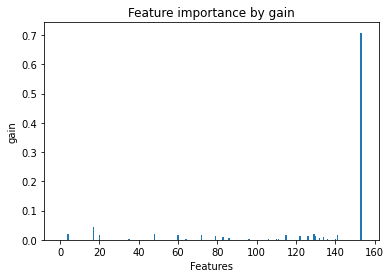

155


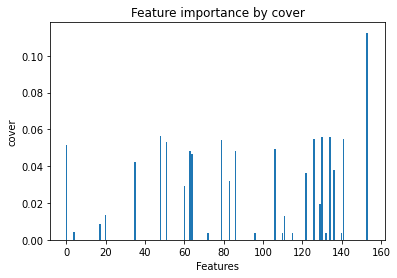

155


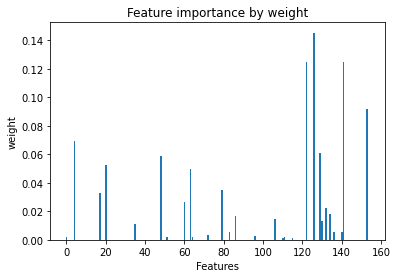

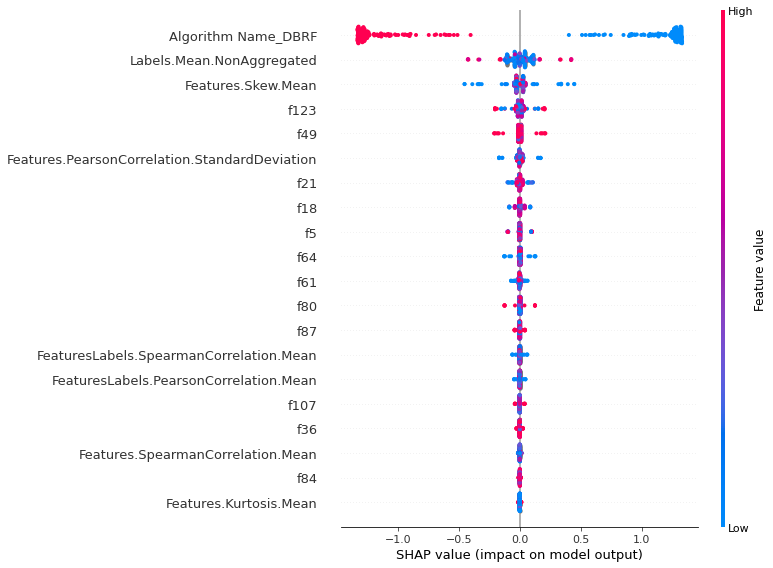

In [21]:
Importance_and_Shap(df_labeled_enco)